In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

### Define paths for the model and data of interest

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/binary/"
chrom_set = ["chr1"]
input_length = 1000
fourier_att_prior_freq_limit = 160
fourier_att_prior_freq_limit_softness = 0.2
att_prior_grad_smooth_sigma = 3
task_index = None

In [ ]:
# SPI1
condition_name = "SPI1"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/binary/config/SPI1/SPI1_training_paths.json")
num_tasks = 4
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1/4/model_ckpt_epoch_2.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/16/model_ckpt_epoch_6.pt")

In [ ]:
# GATA2
condition_name = "GATA2"
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/binary/config/GATA2/GATA2_training_paths.json")
num_tasks = 4
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2/8/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/21/model_ckpt_epoch_6.pt")

In [ ]:
# K562
condition_name = "K562"
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/binary/config/K562/K562_training_paths.json")
num_tasks = 1
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "K562/28/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior/9/model_ckpt_epoch_8.pt")

In [4]:
# BPNet
condition_name = "BPNet"
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/binary/config/BPNet_training_paths.json")
num_tasks = 3
task_index = None
model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "BPNet/22/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/27/model_ckpt_epoch_11.pt")

### Import models

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [6]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [7]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates to data needed for the model

In [8]:
input_func = data_loading.get_binary_input_func(
    files_spec_path, input_length, reference_fasta
)
pos_bins = data_loading.get_positive_binary_bins(
    files_spec_path, task_ind=task_index, chrom_set=chrom_set
)

### Shap explainer
Create DeepSHAP explainers

In [9]:
noprior_shap_explainer = compute_shap.create_binary_explainer(
    noprior_model, input_length, task_index=task_index
)

In [10]:
prior_shap_explainer = compute_shap.create_binary_explainer(
    prior_model, input_length, task_index=task_index
)

### Compute loss values over test set

In [11]:
# Sample a subset of bins randomly to compute predictions for
num_samples = 1000
rng = np.random.RandomState(20200318)
sample_bins = pos_bins[np.random.choice(len(pos_bins), size=num_samples, replace=False)]

In [12]:
noprior_preds = compute_predictions.get_binary_model_predictions(                                              
    noprior_model, sample_bins, input_func,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


In [13]:
prior_preds = compute_predictions.get_binary_model_predictions(                                              
    prior_model, sample_bins, input_func,                        
    fourier_att_prior_freq_limit=fourier_att_prior_freq_limit,
    fourier_att_prior_freq_limit_softness=fourier_att_prior_freq_limit_softness,
    att_prior_grad_smooth_sigma=att_prior_grad_smooth_sigma,
    return_losses=True, return_gradients=True, show_progress=True                                         
)

100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


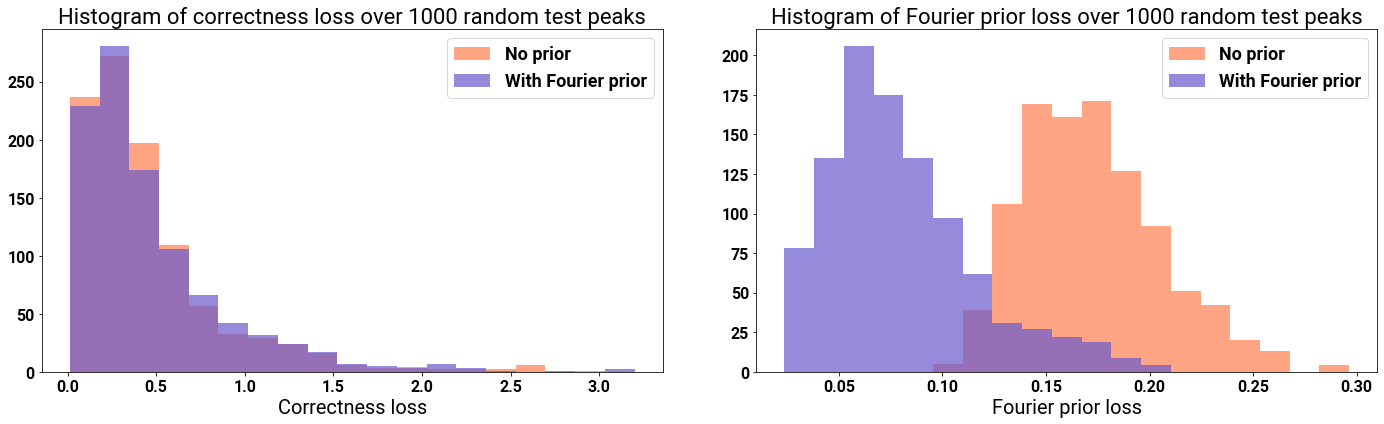

In [14]:
# Plot histogram of profile loss and prior loss over these conditions
bin_num = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
all_vals = np.concatenate([noprior_preds["corr_losses"], prior_preds["corr_losses"]])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
ax[0].hist(noprior_preds["corr_losses"], bins=bins, color="coral", label="No prior", alpha=0.7)
ax[0].hist(prior_preds["corr_losses"], bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
ax[0].set_title("Histogram of correctness loss over %d random test peaks" % num_samples)
ax[0].set_xlabel("Correctness loss")
ax[0].legend()
all_vals = np.concatenate([noprior_preds["att_losses"], prior_preds["att_losses"]])
bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
ax[1].hist(noprior_preds["att_losses"], bins=bins, color="coral", label="No prior", alpha=0.7)
ax[1].hist(prior_preds["att_losses"], bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
ax[1].set_title("Histogram of Fourier prior loss over %d random test peaks" % num_samples)
ax[1].set_xlabel("Fourier prior loss")
ax[1].legend()
plt.tight_layout()

### Distribution of gradients and SHAP scores

In [15]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    shap_explainer = compute_shap.create_binary_explainer(
        model, input_length, task_index=task_index
    )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        input_seqs, _, _ = input_func(batch)
        shap_scores = shap_explainer(
            input_seqs, hide_shap_output=True
        )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [16]:
noprior_grads = noprior_preds["input_grads"]
prior_grads = prior_preds["input_grads"]

In [17]:
noprior_shap, _ = compute_shap_scores(noprior_model, sample_bins)
prior_shap, one_hot_seqs = compute_shap_scores(prior_model, sample_bins)
assert np.all(one_hot_seqs == noprior_preds["input_seqs"])

In [18]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [19]:
def fourier_highfreq_mags(imp_scores, freq_limit):
    """
    For an N x I x 4 array of actual importance scores, computes the sum of the
    Fourier magnitudes in high frequencies, defined by `freq_limit`. Returns an
    N-array of Fourier scores (i.e. sum of low-frequency magnitudes)
    """
    scores = []
    # Normalize
    imp_scores_sum = np.sum(np.abs(imp_scores), axis=2)  # Make into N x I
    
    for score_track in imp_scores_sum:
        freqs, mags = dft(score_track)
        freqs, mags = freqs[1:], mags[1:]  # Cut off DC
        mags = mags / np.sum(mags)  # Normalize
        scores.append(np.sum(mags[freq_limit:]))
    return np.array(scores)

In [20]:
def entropy(imp_scores, pseudocount=0.001):
    """
    For an N x I x 4 array of actual importance scores, computes the entropy
    of each track. Returns an N-array of entropy values.
    """
    scores = []
    # Normalize
    imp_scores_sum = np.sum(np.abs(imp_scores), axis=2)  # Make into N x I
    imp_scores_sum = imp_scores_sum + pseudocount
    imp_scores_norm = imp_scores_sum / np.sum(imp_scores_sum, axis=1, keepdims=True)
    
    return -np.sum(imp_scores_norm * np.log2(imp_scores_norm), axis=1)

In [21]:
noprior_grad_fourier_scores = fourier_highfreq_mags(noprior_grads * one_hot_seqs, fourier_att_prior_freq_limit)
prior_grad_fourier_scores = fourier_highfreq_mags(prior_grads * one_hot_seqs, fourier_att_prior_freq_limit)
noprior_grad_entropy_scores = entropy(noprior_grads * one_hot_seqs)
prior_grad_entropy_scores = entropy(prior_grads * one_hot_seqs)

In [22]:
noprior_shap_fourier_scores = fourier_highfreq_mags(noprior_shap * one_hot_seqs, fourier_att_prior_freq_limit)
prior_shap_fourier_scores = fourier_highfreq_mags(prior_shap * one_hot_seqs, fourier_att_prior_freq_limit)
noprior_shap_entropy_scores = entropy(noprior_shap * one_hot_seqs)
prior_shap_entropy_scores = entropy(prior_shap * one_hot_seqs)

In [23]:
def plot_global_smoothness(
    noprior_imp_fourier_scores, prior_imp_fourier_scores, noprior_imp_entropy_scores,
    prior_imp_entropy_scores, imp_type
):
    bin_num = 20
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    all_vals = np.concatenate([noprior_imp_fourier_scores, prior_imp_fourier_scores])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
    ax[0].hist(noprior_imp_fourier_scores, bins=bins, color="coral", label="No prior", alpha=0.7)
    ax[0].hist(prior_imp_fourier_scores, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
    ax[0].set_xlabel("Sum of high-frequency Fourier magnitudes")
    all_vals = np.concatenate([noprior_imp_entropy_scores, prior_imp_entropy_scores])
    bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
    ax[1].hist(noprior_imp_entropy_scores, bins=bins, color="coral", label="No prior", alpha=0.7)
    ax[1].hist(prior_imp_entropy_scores, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
    ax[1].set_xlabel("Entropy")
    ax[1].legend()
    title = "Histograms of smoothness of %s" % imp_type
    title += "\n%s binary models" % condition_name
    title += "\nComputed on %d randomly drawn test peaks" % num_samples
    fig.suptitle(title)
    plt.subplots_adjust(top=0.80)
    plt.show()
    
    def draw_xy_line(ax):
        limits = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(limits, limits, "--", alpha=0.5, color="black")
        ax.set_aspect("equal")
        ax.set_xlim(limits)
        ax.set_ylim(limits)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax[0].scatter(noprior_imp_fourier_scores, prior_imp_fourier_scores, color="mediumorchid")
    ax[0].set_xlabel("High frequency sum without prior")
    ax[0].set_ylabel("High frequency sum with Fourier prior")
    ax[1].scatter(noprior_imp_entropy_scores, prior_imp_entropy_scores, color="mediumorchid")
    ax[1].set_xlabel("Entropy without prior")
    ax[1].set_ylabel("Entropy with Fourier prior")
    draw_xy_line(ax[0])
    draw_xy_line(ax[1])
    title = "Pairwise comparison of %s smoothness" % imp_type
    title += "\n%s binary models" % condition_name
    title += "\nComputed on %d randomly drawn test peaks" % num_samples
    fig.suptitle(title)
    plt.subplots_adjust(top=0.80)
    plt.show()
    
    print("High-frequency Fourier sum:")
    print("Average without priors: %f" % np.nanmean(noprior_imp_fourier_scores))
    print("Average with priors: %f" % np.nanmean(prior_imp_fourier_scores))
    w, p = scipy.stats.wilcoxon(noprior_imp_fourier_scores, prior_imp_fourier_scores, alternative="greater")
    print("One-sided Wilcoxon test: w = %f, p = %f" % (w, p))
    print("Entropy:")
    print("Average without priors: %f" % np.nanmean(noprior_imp_entropy_scores))
    print("Average with priors: %f" % np.nanmean(prior_imp_entropy_scores))
    w, p = scipy.stats.wilcoxon(noprior_imp_entropy_scores, prior_imp_entropy_scores, alternative="greater")
    print("One-sided Wilcoxon test: w = %f, p = %f" % (w, p))

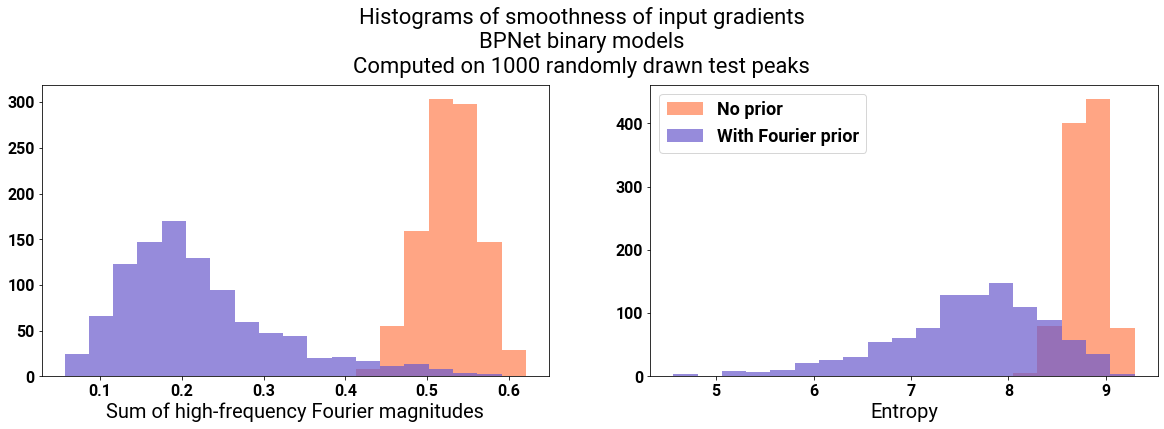

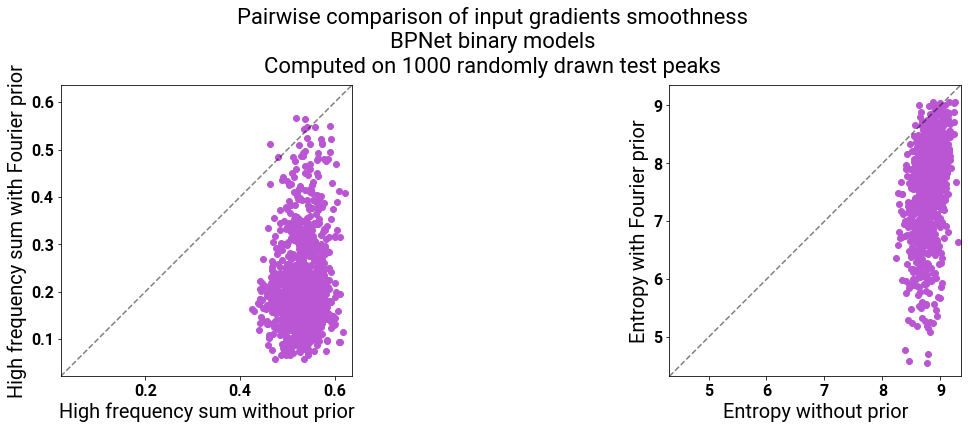

In [24]:
plot_global_smoothness(
    noprior_grad_fourier_scores, prior_grad_fourier_scores, noprior_grad_entropy_scores,
    prior_grad_entropy_scores, "input gradients"
)

High-frequency Fourier sum:
Average without priors: 0.528021
Average with priors: 0.220329
One-sided Wilcoxon test: w = 500450.000000, p = 0.000000
Entropy:
Average without priors: 8.799414
Average with priors: 7.588846
One-sided Wilcoxon test: w = 500105.000000, p = 0.000000


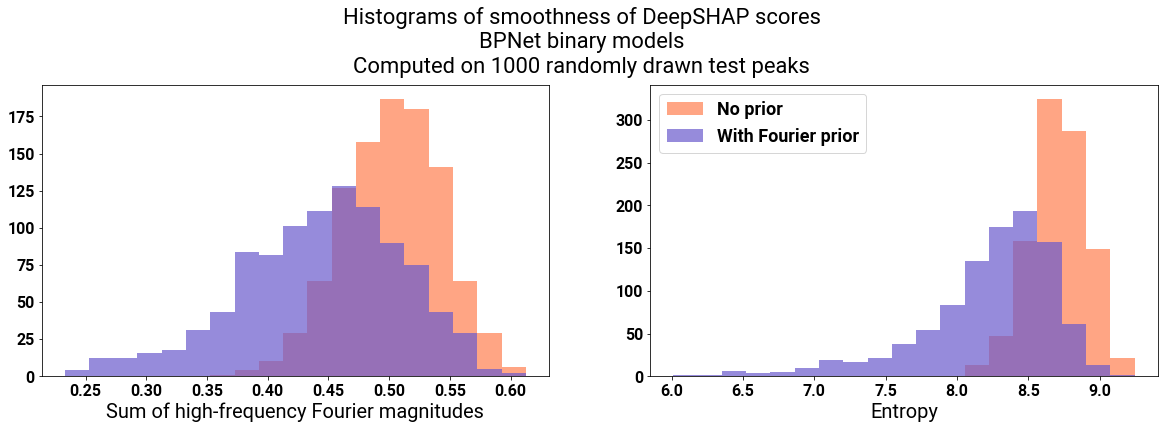

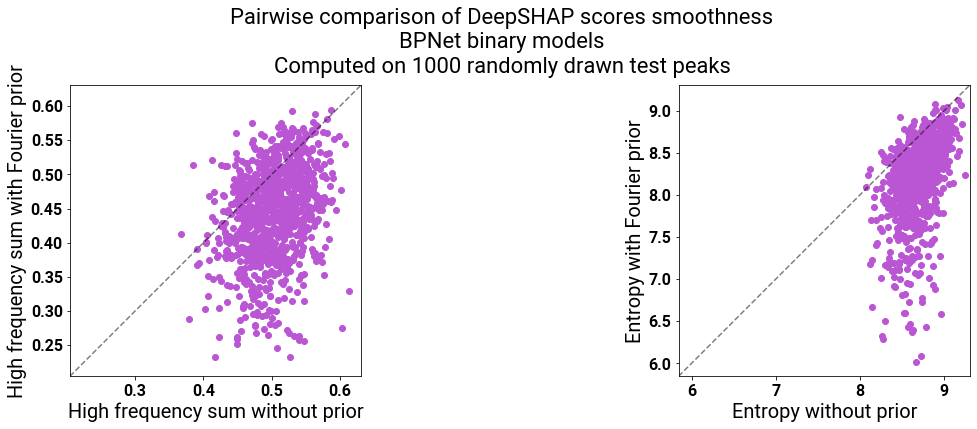

High-frequency Fourier sum:
Average without priors: 0.502614
Average with priors: 0.444012
One-sided Wilcoxon test: w = 451498.000000, p = 0.000000
Entropy:
Average without priors: 8.711133
Average with priors: 8.225784
One-sided Wilcoxon test: w = 494244.000000, p = 0.000000


In [25]:
plot_global_smoothness(
    noprior_shap_fourier_scores, prior_shap_fourier_scores, noprior_shap_entropy_scores,
    prior_shap_entropy_scores, "DeepSHAP scores"
)

### Plotting functions

In [26]:
def plot_fft(signal, include_dc=False, pos_limit=None, title=None):
    abs_signal = np.abs(signal)
    
    freqs, mags = dft(abs_signal)
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
        
    plt.figure(figsize=(20, 2))
    plt.plot(freqs, mags, color="red")
    plt.xlabel("Frequency (radians)")
    plt.ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(signal)
        plt.axvline(x=pos_limit_radians, color="black")
    if title:
        plt.title(title)
    plt.show()

In [27]:
def plot_signal(signal, title=None, color=None):
    plt.figure(figsize=(20, 2))
    plt.plot(signal, color=color)
    if title:
        plt.title(title)
    plt.show()

### View predictions

In [28]:
def predict_and_plot(
    model, shap_explainer, bin_index, with_priors, show_sequences=True, seq_slices=[slice(650, 750)]
):
    if type(seq_slices) is not list:
        seq_slices = [seq_slices]
    results = compute_predictions.get_binary_model_predictions(                                              
        model, np.array([bin_index]), input_func,                      
        return_losses=False, return_gradients=True, show_progress=False                                         
    )
    coords = results["coords"]
    input_seqs = results["input_seqs"]
    input_grads = results["input_grads"]

    chrom, start, end = coords[0]
    print("%s:%d-%d" % (chrom, start, end))
    
    color = "slateblue" if with_priors else "coral"
    print("Input gradients and Fourier transform")
    plot_signal(np.sum(input_grads[0] * input_seqs[0], axis=1), title="Input gradients", color=color)
    plot_fft(np.sum(input_grads[0] * input_seqs[0], axis=1), pos_limit=200, title="Fourier transform of input gradients")
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(input_grads[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)
    
    print("DeepSHAP scores")
    hyp_shap_scores = shap_explainer(input_seqs, hide_shap_output=True)
    plot_signal(np.sum(hyp_shap_scores[0] * input_seqs[0], axis=1), title="DeepSHAP scores", color=color)
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(hyp_shap_scores[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((hyp_shap_scores[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)
    
    print("ISM scores")
    hyp_ism_scores = compute_ism.get_binary_model_ism(model, input_seqs, task_index=task_index)
    plot_signal(np.sum(hyp_ism_scores[0] * input_seqs[0], axis=1), title="ISM scores", color=color)
    if show_sequences:
        for seq_slice in seq_slices:
            viz_sequence.plot_weights(hyp_ism_scores[0][seq_slice], subticks_frequency=1000)
            viz_sequence.plot_weights((hyp_ism_scores[0] * input_seqs[0])[seq_slice], subticks_frequency=1000)

In [29]:
# Sample some random peaks
pos_bins[np.random.choice(len(pos_bins), size=10, replace=False)]

array([1512921, 3680926, 2737584, 3066551, 3577004,  169919, 1659471,
        676577, 3603909, 2673345])

In [30]:
# The bins that show the most improvement in prior loss
sample_bins[np.flip(np.argsort(noprior_preds["att_losses"] - prior_preds["att_losses"]))][:40]

array([ 915898, 3416859, 3596065, 1303576,  861963, 1192070, 3417699,
       3066394,  915897, 2649620,  740268, 1509539,  720340, 1042266,
        282751, 1502846, 1794783,  726806, 1952446,  538150, 1164729,
       2381065, 1456550,  475000, 3419259, 2703915, 2638666,  861961,
       1264940, 3423761, 3029355, 2475200, 3290632, 1281591,  875698,
       3889443, 2386931, 3830306, 3068490, 3447516])

In [ ]:
# SPI1
bin_index = 577670
seq_slices = [slice(400, 600)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# GATA2
bin_index = 4484095
seq_slices = [slice(225, 275), slice(300, 500)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# K562
bin_index = 2254287
seq_slices = [slice(425, 475), slice(600, 650)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# BPNet
bin_index = 1444378  # Nanog
seq_slices = [slice(475, 575)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# BPNet
bin_index = 2998255  # Nanog
seq_slices = [slice(450, 550)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# BPNet
bin_index = 2546769  # Nanog
seq_slices = [slice(600, 700)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)

In [ ]:
# BPNet
bin_index = 1790322  # Nanog
seq_slices = [slice(600, 700)]
show_sequences = True
predict_and_plot(noprior_model, noprior_shap_explainer, bin_index, False, show_sequences, seq_slices)
predict_and_plot(prior_model, prior_shap_explainer, bin_index, True, show_sequences, seq_slices)